In [1]:
#imported libs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import get_file
import os


In [2]:
#dataset_dir  = r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\101_ObjectCategories"
dataset_dir = r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories"



# Parameters
batch_size = 32
image_size = (64, 128)

# Load the training and validation datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)


def dataset_to_numpy(dataset):
    """
    Convert a tf.data.Dataset into NumPy arrays for features and labels.
    Args:
        dataset: A tf.data.Dataset object.
    Returns:
        X: Numpy array of features (images).
        y: Numpy array of labels.
    """
    X = []
    y = []
    for images, labels in dataset:
        X.append(images.numpy())
        y.append(labels.numpy())
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

# Convert the train and validation datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(val_dataset)

X_test =[cv2.resize(img.astype(np.uint8), (64, 128)) for img in X_test]
X_train=[cv2.resize(img.astype(np.uint8), (64, 128)) for img in X_train]


Found 9145 files belonging to 101 classes.
Using 7316 files for training.
Found 9145 files belonging to 101 classes.
Using 1829 files for validation.


In [51]:
#Accuracy
def accuracy(y_test1, y_pred1):
    y_pred1 = np.array(y_pred1)
    counter = 0
    for i in range(len(y_pred1)):
      if (y_pred1[i] == y_test1[i]):
        counter += 1
    accuracy = counter / len(y_pred1)
    accuracy *= 100
    return accuracy

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# visualizing the results
def visualize_results(y_test,y_predict):
    class_names = [folder for folder in os.listdir(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories") if os.path.isdir(os.path.join(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories", folder))]
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Calculate accuracy for each class
    class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Display class-wise accuracy
    #classes = [f"Class {i}" for i in range(len(class_accuracies))]  # Replace with actual class names if available

    # Plot the accuracies
    plt.figure(figsize=(15, 5))
    plt.bar(class_names, class_accuracies, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Class-Wise Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 100)  # Accuracy is in percentage
    plt.tight_layout()
    plt.show()

In [3]:
#Color Histogran Extraction def
def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    Extract a 3D color histogram from an RGB image.
    Args:
        image (numpy array): Input image in RGB format.
        bins (tuple): Number of bins for each channel (R, G, B).
    Returns:
        numpy array: Flattened color histogram feature vector.
    """
    # Calculate the 3D histogram for the HSV channels
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 255, 0, 255, 0, 255])
    # Normalize the histogram to ensure invariance to lighting changes
    hist = cv2.normalize(hist, hist).flatten()

    return hist

In [4]:
#HOG def
def extract_hog_features(image):
       # HOG parameters
    winSize = (64, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog_features = hog.compute(image)
     
    return hog_features

In [5]:
#LBP def
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, num_points=32, radius=8):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grid_size = (8, 8)  # Divide image into a 8x8 grid for histograms
     # Compute LBP
    lbp = local_binary_pattern(gray_img, num_points, radius, method="uniform")
    h, w = lbp.shape
    
    # Divide the image into grids and compute histograms
    grid_h, grid_w = h // grid_size[0], w // grid_size[1]
    histograms = []
    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            grid = lbp[i * grid_h:(i + 1) * grid_h, j * grid_w:(j + 1) * grid_w]
            hist, _ = np.histogram(grid, bins=np.arange(0, num_points + 3), density=True)
            histograms.append(hist)
    
    # Concatenate histograms
    return np.concatenate(histograms)

In [6]:
# Step 1: Extract LBP features for train and test
lbp_features_train = np.array([extract_lbp_features(image) for image in X_train])
lbp_features_test  = np.array([extract_lbp_features(image) for image in X_test])

In [7]:
# Step 2: Extract HOG features for train and test
hog_features_train = np.array([extract_hog_features(image) for image in X_train])
hog_features_test  = np.array([extract_hog_features(image) for image in X_test])

In [8]:
# Step 3: Extract Color Histogram features for train and test
clhg_features_train = np.array([extract_color_histogram(image) for image in X_train])
clhg_features_test  = np.array([extract_color_histogram(image) for image in X_test])

In [80]:
import numpy as np
from collections import Counter
class KMeans:
    def __init__(self, n_clusters=101, max_iter=300, tol=1e-6):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol  # Tolerance for convergence
        self.matching_list= np.zeros(101, dtype=int)

    def fit(self, X):
        # Step 1: Randomly initialize centroids
        np.random.seed(42)
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        print(X.shape[0])
        print (self.centroids.shape)
        for iteration in range(self.max_iter):
            # Step 2: Assign points to the nearest cluster ,holds the cluster no. of each point in x_train
            self.labels = self._assign_clusters(X)

            # Step 3: Compute new centroids
            new_centroids = np.array([  X[self.labels == i].mean(axis=0) for i in range(self.n_clusters)  ])

            # Check for convergence
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                print(f"Converged at iteration {iteration}")
                #after coverging , get the matching class for the clusters
                self._match_cluster(X)# will update the matching list
                break

            self.centroids = new_centroids

    def _assign_clusters(self, X):
        #My implementation , faster implementation than chatgpt implementation
        distances=[]
        for i in range (len(X) ):
            distances.append(     np.linalg.norm(self.centroids - X[i] , axis=1)    ) #minus all centroid by the given point , put it in an array , get the minimum of this array
        return np.argmin(  np.array(distances) , axis = 1  )
    
        '''# Compute distances from each point to each centroid
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) #(distances.shape) 7316 x 100 , 100 euclidean distances for each img in the data set
        return np.argmin(distances, axis=1)  # Assign each point to the nearest centroid'''

    def predict(self, X): #real predict function that will be used by the user
        X = np.array(X).flatten()
        # Compute the Euclidean distances between the test case and all centroids
        distances = np.linalg.norm(self.centroids - X, axis=1)   # (101 x no. of features) - (1 X no.of features)   , broadcasting occurs = (101 X ,)
        #return self.matching_list[   np.argmin(distances)  ]  #smallest distance resemble the cluster it belongs to , we need the matching class of this cluster
        return np.where(self.matching_list == np.argmin(distances) )[0]

    
    """def _match_cluster(self):
        for i in range(self.n_clusters):
            # Find all points belonging to cluster `i`
            cluster_indices = np.where(self.labels == i)[0]  # Get points in this cluster

            # Map each cluster to the most common true label
            if len(cluster_indices) > 0:  # Avoid empty clusters
                true_labels = y_train[cluster_indices]  # True labels of the points in the cluster
                self.matching_list[i] = Counter(true_labels).most_common(1)[0][0]  # Most frequent label"""

    
    
    def _predictt(self,X):#mockup predict function to be used by the _match_cluster
        X = np.array(X).flatten()
        # Compute the Euclidean distances between the test case and all centroids
        distances = np.linalg.norm(self.centroids - X, axis=1)   # (101 x no. of features) - (1 X no.of features)   , broadcasting occurs = (101 X ,)
        return np.argmin(distances)
        
    #My implementation for matching each cluster number with a real class number
    def _match_cluster(self,X):
        for i in range (self.n_clusters):
            cluster_indices = np.where(y_train==i)[0]
            y_pred = np.array([   self._predictt ( X[x].reshape(1, -1))  for x in cluster_indices   ])
            self.matching_list[i]= Counter(y_pred).most_common(1)[0][0]

In [61]:
model = KMeans()
model.fit(lbp_features_train)

7316
(101, 2176)
Converged at iteration 29


32.91416074357573


C:\Users\Omar Wessam\AppData\Local\Temp\ipykernel_21836\1576534041.py:12: RuntimeWarning: invalid value encountered in divide
  class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100


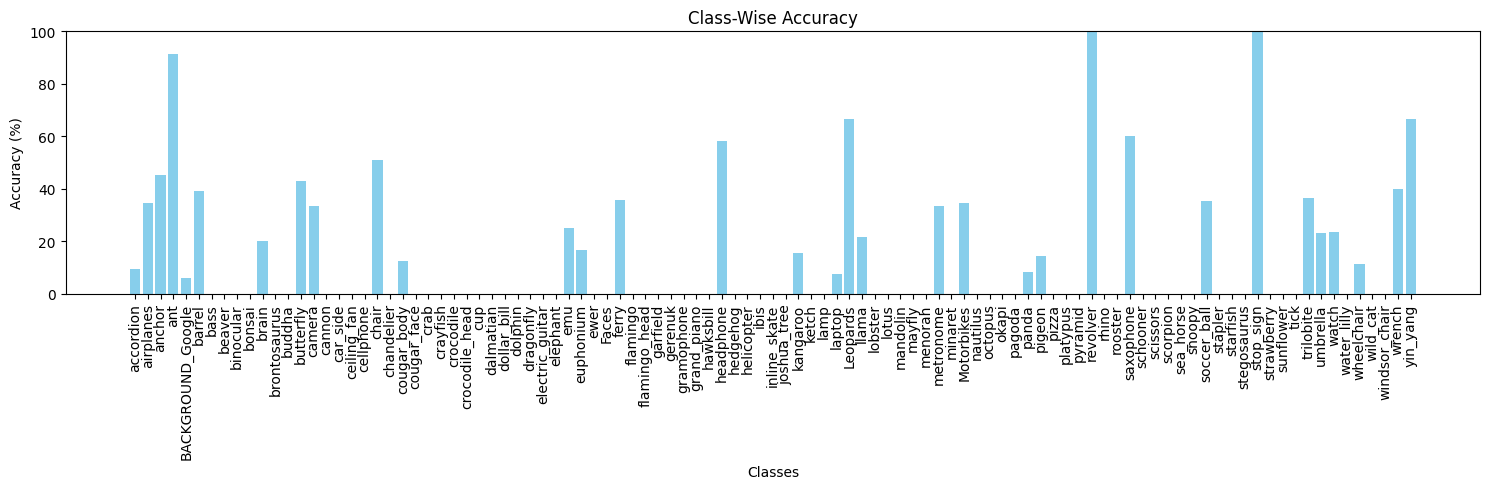

In [66]:
y_lbp = np.array([   model.predict(x.reshape(1, -1)) for x in lbp_features_test   ]) 
print(accuracy( y_lbp , y_test ))
visualize_results(y_lbp , y_test)


In [69]:
model2 = KMeans()
model2.fit(hog_features_train)

7316
(101, 3780)
Converged at iteration 30


41.388737014762164


C:\Users\Omar Wessam\AppData\Local\Temp\ipykernel_21836\1576534041.py:12: RuntimeWarning: invalid value encountered in divide
  class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100


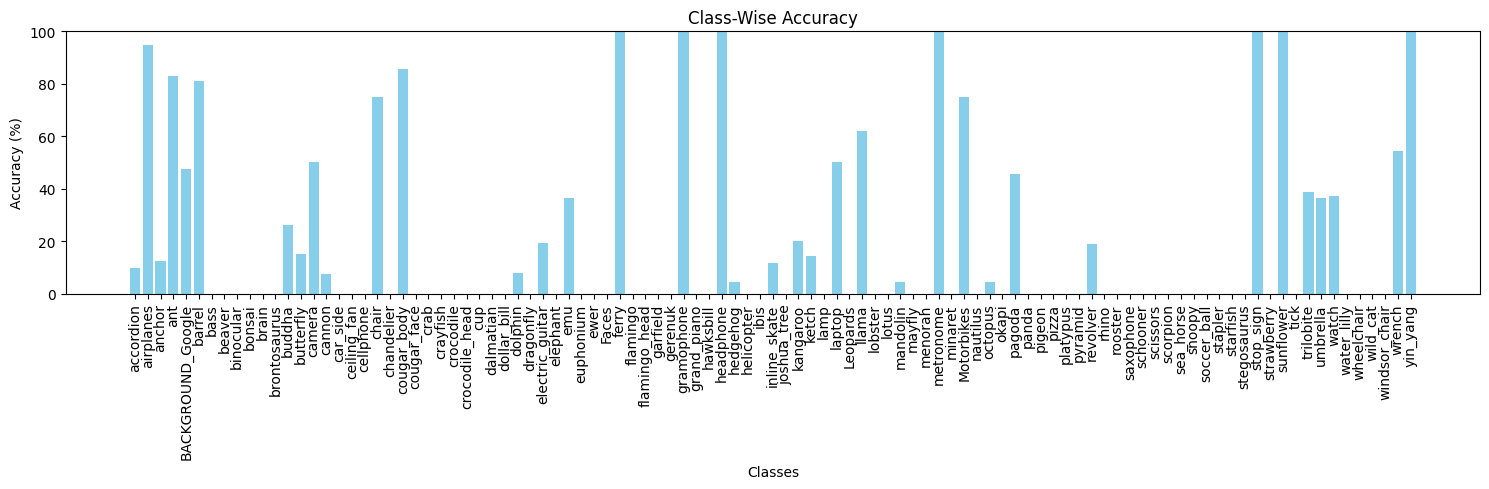

In [ ]:
y_hog = np.array([   model2.predict(x.reshape(1, -1)) for x in hog_features_test   ]) 
print(accuracy(y_hog , y_test ))
visualize_results(y_hog , y_test)

In [ ]:
model3 = KMeans()
model3.fit(clhg_features_train)

7316
(101, 512)
Converged at iteration 28


In [ ]:
y_clhg = np.array([model3.predict(x.reshape(1, -1))[0] for x in clhg_features_test]) 
print(accuracy( y_clhg , y_test ))
visualize_results(y_clhg , y_test)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:


"""My implementation for matching each cluster number with a real class number
from collections import Counter
matching_list= np.zeros(101, dtype=int)

cluster_indices = np.where(y_train==4)[0]
y_pred = np.array([   model.predict(lbp_features_train[x].reshape(1, -1)) for x in cluster_indices   ])
matching_list[4]= Counter(y_pred).most_common(1)[0][0]

print(matching_list[4])"""
    
"""matching_list=[]
for i in range (n_cluster):
    cluster_indices = np.where(y_train==i)[0]
    y_pred = np.array([   model.predict(x_train[x].reshape(1, -1)) for x in cluster_indices   ])
    matching_list[i]= Counter(y_pred).most_common(1)[0][0]
    """
    
    

29


'matching_list=[]\nfor i in range (n_cluster):\n    cluster_indices = np.where(y_train==i)[0]\n    y_pred = np.array([   model.predict(x_train[x].reshape(1, -1)) for x in cluster_indices   ])\n    matching_list[i]= Counter(y_pred).most_common(1)[0][0]\n    '